# Sliced Wasserstein Distance for Learning Gaussian Mixture Models

This notebook walks you through the implementation of our paper:

["Sliced Wasserstein Distance for Learning Gaussian Mixture Models"](https://arxiv.org/abs/1711.05376)

In short, we implement the 'sliced Wasserstein means' problem for estimating parameters of general GMMs. To run this notebook you will require the following packages:

* Numpy
* Matplotlib
* Scipy
* Scikit-Learn

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
import pickle
import matplotlib.animation as manimation
from IPython import display
from utils import *
import time
%matplotlib inline

## Start by testing our implementation of one-dimensional Wasserstein distance

First we test the calculation of transport map, $f$, returned by pWasserstein function to ensure that the returned transport map is meaningful. For this test, we calculate the one-dimensional transport map between two distributions, $I_0$ and $I_1$ and check if the mass preservation constraint (i.e. $I_0=f'I_1(f)$) holds.

/var/folders/z8/5477tlw55pd5y_knhyhtf1f80000gn/T/ipykernel_55848/3453416230.py:12: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  I0_tilde=fprime*interp(f,x,I1) # Calculate f'I_1(f)


Text(0.5, 1.0, "$f'I_1(f)$")

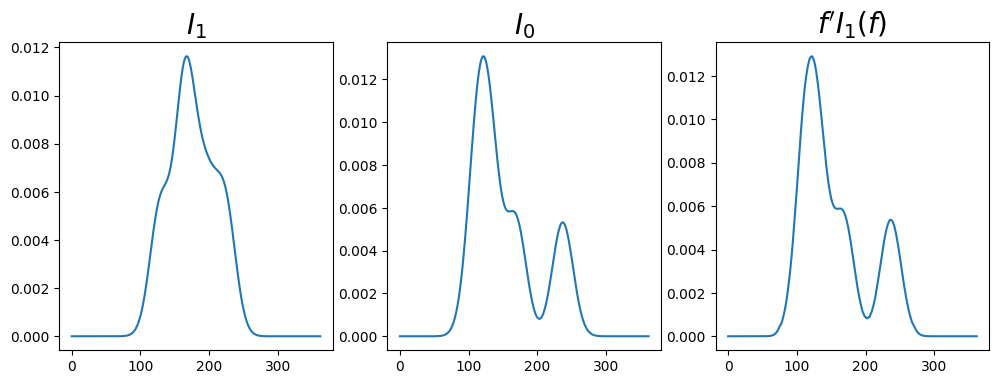

In [2]:
# Load sample probability distributions I_1 and I_0
I=np.load(open('./data/examplePDFs.npy','rb'))
I0=np.squeeze(I[:,0])
I1=np.squeeze(I[:,1])
# Calculate the transport map 
f,phi,Wp=pWasserstein(I0,I1,2)
# Define the domain x
x=np.asarray(range(len(I0)))
# Calculate f'
fprime=np.gradient(f) 
#Calculate f'(x)*I1(f(x))
I0_tilde=fprime*interp(f,x,I1) # Calculate f'I_1(f)

#Visualize the PDFs
fig,[ax1,ax2,ax3]=plt.subplots(1,3,figsize=(12,4))
ax1.plot(I1)
ax1.set_title('$I_1$',fontsize=20)
ax2.plot(I0)
ax2.set_title('$I_0$',fontsize=20)
ax3.plot(I0_tilde)
ax3.set_title('$f\'I_1(f)$',fontsize=20)

It can be seen that the transport map successfully pushes distribution $I_0$ into $I_1$ (i.e. warps $I_1$ into $I_0$). 

/var/folders/z8/5477tlw55pd5y_knhyhtf1f80000gn/T/ipykernel_55848/418470712.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  Iinterp.append(gprime*interp(g,x,I1))


Text(0.5, 1.0, '$\\frac{dg}{dx}I_1(g)$ where $g(x)=(1-\\alpha)x+\\alpha f(x)$ for $\\alpha\\in\\{0,.25,.5,.75,1\\}$')

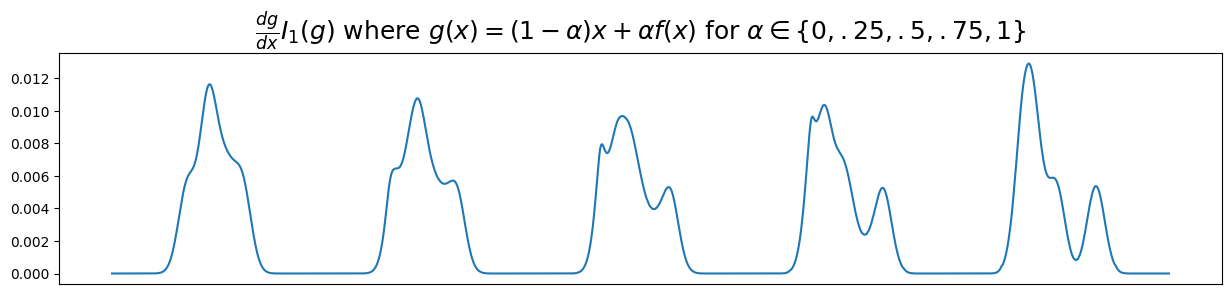

In [3]:
# Just for the fun of it, we interpolate between the two PDFs using the transport map to demonstrate the nonlinear 
# modeling power of optimal mass transportation
Iinterp=[]
for alpha in np.linspace(0,1,5):
    g=(1-alpha)*x+alpha*f
    gprime=np.gradient(g) 
    Iinterp.append(gprime*interp(g,x,I1))
Iinterp=np.reshape(np.array(Iinterp),-1)

fig=plt.figure(figsize=(15,3))
plt.plot(Iinterp)
plt.xticks([])
plt.title(r'$\frac{dg}{dx}I_1(g)$ where $g(x)=(1-\alpha)x+\alpha f(x)$ for $\alpha\in\{0,.25,.5,.75,1\}$',fontsize=18)

Now we are ready to define the sliced-Wasserstein means problem.

## Sliced Wasserstein Means problem: 

Sliced Wasserstein Means (SWM)  problem, 

$$
min_{\mu_k,\Sigma_k,\alpha_k} SW^p_p(I_x,I_y)= \int_{\mathbb{S}^{d-1}} W_p^p(\mathcal{R}I_x(.,\theta),\mathcal{R} I_y(.,\theta)) d\theta,
$$

where 

<center>
$
I_x(x)= \sum_k \alpha_k \frac{1}{(2\pi)^{\frac{d}{2}} \sqrt{det(\Sigma_k)}}exp(-\frac{1}{2}(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k))\\
I_y(y)= \frac{1}{N}\sum_n \phi(y-y_n)
$
</center>

and the $\mathcal{R}$ denotes the Radon transform and is defined as:

$$
\mathcal{R} I(t,\theta):=\int_{\mathbb{R}^d} I(x)\delta(t-x\cdot\theta)dx
$$

And the Radon transformations in the SWM problem could be written as:

<center>
$
\mathcal{R}I_y(t,\theta)\approx \frac{1}{N}\sum_{n=1}^N \mathcal{R}\phi(t-y_n\cdot\theta,\theta)\\ \\
\mathcal{R}I_x(t,\theta)= \sum_k \frac{\alpha_k}{\sqrt{2\pi\theta^T\Sigma_k\theta}}exp(-\frac{(t-\mu_k\cdot\theta)^2}{2\theta^T\Sigma_k\theta})
$
</center>

## In what follows we implement the sliced Wasserstein means problem for a 2D example

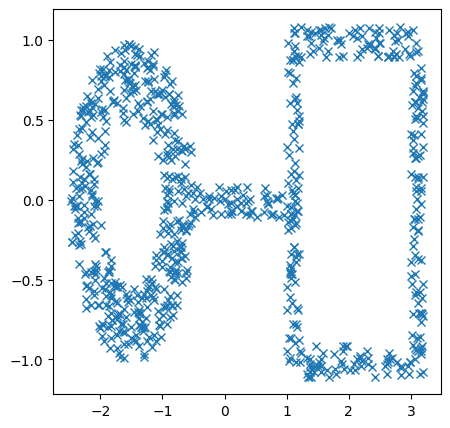

In [4]:
# Load the Ring-Line-Square data and plot it
Y=np.loadtxt('./data/ring-line-square.txt',delimiter=' ')
Y=Y-Y.mean(axis=0)
plt.figure(figsize=(5,5))
plt.plot(Y[:,0],Y[:,1],'x',zorder=0)
plt.show()

### Setup our GMM parameters and initialize it

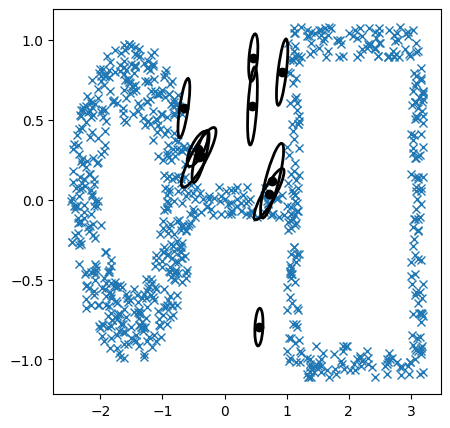

In [5]:
K=10 # Number of Models (number of Gaussians)
d=2  # Dimension of the problem

Sigma_=[] # Covariance
mu_=[]    # Mean
alpha_=[] # Weight
for k in range(K):
    S=.1*np.random.rand(d,d)
    S=np.dot(S,S.T)+.001*np.eye(d)
    m=2*(np.random.rand(d)-0.5)
    a=1.
    Sigma_.append(S)
    mu_.append(m)
    alpha_.append(a)
alpha_=np.array(alpha_)
alpha_=alpha_/alpha_.sum()

# Plot the initialization
plt.figure(figsize=(5,5))
plt.plot(Y[:,0],Y[:,1],'x',zorder=0)
for k in range(K):
    plot_cov_ellipse(mu_[k],Sigma_[k], nstd=2, ax=None)
    plt.scatter(mu_[k][0],mu_[k][1],c='k',marker='o',linewidth=1,zorder=5)
plt.show()

In [6]:
# Setup the video write for capturing the optimization steps
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='SWGMM', artist='skolouri',
                comment='This movie demonstrates the steps of SWGMM!')
writer = FFMpegWriter(fps=15, metadata=metadata)

### Run the optimization 

Note that for the last few iterations we will actually use EM as it makes the code much faster.

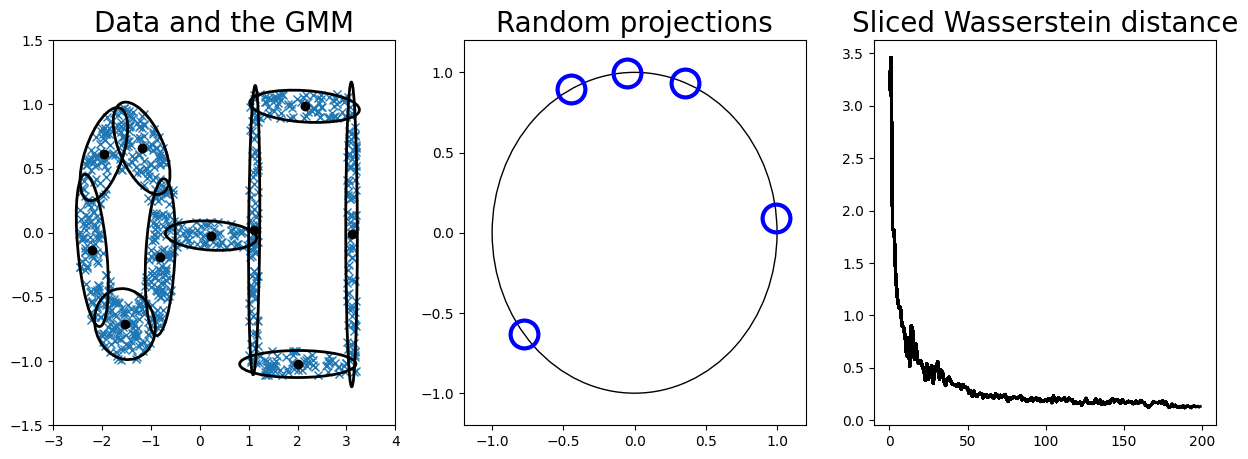

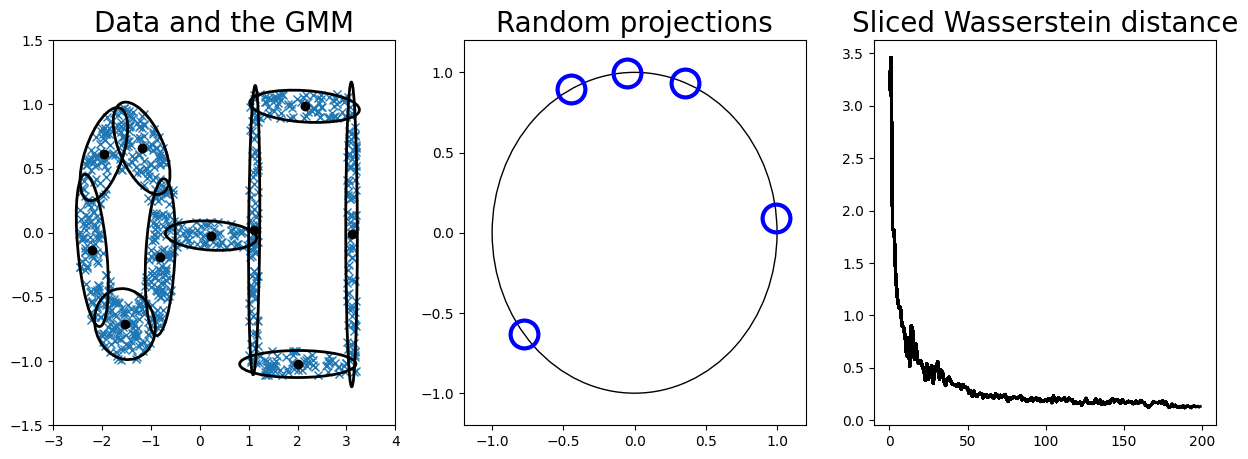

In [7]:
L=5   #Number of slices
T=2000 #The projection resolution (bins of the projected data)

# RMSProp parameters (decay, etc.)
lr=5e-2
gamma=0.9
momentum=.5
epsilon=1e-10
itr=0

# RMSProp variables (This function does not change \alpha and only changes Covariance and mean assuming
# that classes have same number of members. )
# To do: Add the alpha updates!

# g is the first order momentum
# m is the second order momentum
# v is the RMSProp update

gSigma=[]
mSigma=[]
vSigma=[]

gMu=[]
mMu=[]
vMu=[]

# Initialize the RMSProp variables with zeros

for k in range(K):
    gSigma.append(np.zeros((d,d)))
    mSigma.append(np.zeros((d,d)))
    vSigma.append(np.zeros((d,d)))
    gMu.append(np.zeros((d,)))
    mMu.append(np.zeros((d,)))
    vMu.append(np.zeros((d,)))

# t is the projection indices
t=np.linspace(-np.abs(Y).max()*np.sqrt(2*d),np.abs(Y).max()*np.sqrt(2*d),T)

# Assign placeholders for SW distance and loglikelihoods
sw=[]
lls=[]
fig,[ax1,ax2,ax3]=plt.subplots(1,3,figsize=(15,5))
with writer.saving(fig, "SWM_GMM_10_G.mp4", 100):
    while 1:
        # First slice the data
        theta=generateTheta(L,d)
        yproj=np.matmul(Y,theta.T)
        # Now slice the GMM 
        projectedSigma=np.zeros((K,L))
        projectedMu=np.zeros((K,L))
        for k,(sig,m) in enumerate(zip(Sigma_,mu_)):
            for l,th in enumerate(theta):        
                projectedSigma[k,l]=np.sqrt(np.matmul(np.matmul(th,sig),th))
                projectedMu[k,l]=np.matmul(th,m)
        #For a fixed GMM find f(.,\theta) or equivalently phi(.,\theta) (phi is the potential function)
        phi=np.zeros((T,L))
        sw_=0
        for l in range(L):
            RIx=gmm1d(t,projectedMu[:,l],projectedSigma[:,l],alpha_)
            RIy=gaussKernel(t,yproj[:,l])
            f,phi_,w2=pWasserstein(RIx,RIy,p=2)
            phi[:,l]=phi_
            sw_+= w2/float(L)
        sw.append(sw_)
        lls.append(logLikelihood(Y,mu_,Sigma_,alpha_))
        # For fixed transport maps f(.,\theta), update \mu and \Sigma
        dSWdSigma=[]
        dSWdMu=[]

        itr+=1        
        
        for k in range(K):
            Ixkl=np.array([gaussian1d(t,projectedMu[k,l],projectedSigma[k,l]) for l in range(L)]).T
            tSt=np.tile(projectedSigma[k,:]**2,(T,1))
            tmm=np.tile(t,(L,1)).T-np.tile(projectedMu[k,:],(T,1))
            
            # Caclulate gradient with respect to \mu (Mean)
            dSWdMu.append(((np.tile(((alpha_[k]*(phi)*Ixkl*tmm/tSt).mean(0)),(d,1)).T)*theta).mean(0))        
            # Calculate gradient with respect to \Sigma (Covariance)
            dsWdSigmakCoeff=(alpha_[k]*(phi)*Ixkl*(1.0/(2*tSt**2))*((tmm**2)/tSt-1)).mean(0)
            dSWdSigmak_=[dsWdSigmakCoeff[i]*np.matmul(np.expand_dims(th,1),np.expand_dims(th,1).T) for i,th in enumerate(theta)]
            dSWdSigma.append(np.asarray(dSWdSigmak_).mean(0))
            
            # Update g,m, and v variables of RMSProp for Sigma
            gSigma[k]=gamma*gSigma[k]+(1-gamma)*(dSWdSigma[k]**2) #Second order moment
            mSigma[k]=gamma*mSigma[k]+(1-gamma)*(dSWdSigma[k])    #First order moment
            vSigma[k]=momentum*vSigma[k]-lr*dSWdSigma[k]/(np.sqrt(gSigma[k]-(mSigma[k]**2)+epsilon))
            
            # Update g,m, and v variables of RMSProp for mu
            gMu[k]=gamma*gMu[k]+(1-gamma)*(dSWdMu[k]**2) #Second order moment
            mMu[k]=gamma*mMu[k]+(1-gamma)*(dSWdMu[k])#First order moment
            vMu[k]=momentum*vMu[k]-lr*dSWdMu[k]/(np.sqrt(gMu[k]-(mMu[k]**2)+epsilon))
            
            # Update Sigma
            Sigma_[k]+=0.1*vSigma[k] # The .1 coefficient makes the method converge nicer! 
            Sigma_[k]=projectPD(Sigma_[k]) # Ensure Sigma remains positive definite (i.e. project it onto the PD matrices)
            mu_[k]+=vMu[k]
    
        # Plot what is going on!
        ax1.clear()
        ax1.plot(Y[:,0],Y[:,1],'x',zorder=0)
        for i in range(K):
            plot_cov_ellipse(mu_[i],Sigma_[i], nstd=2, ax=ax1)
            ax1.scatter(mu_[i][0],mu_[i][1],c='k',marker='o',linewidth=1,zorder=5)        
        ax1.set_xlim(-3,4)
        ax1.set_ylim(-1.5,1.5)
        ax1.set_title('Data and the GMM',fontsize=20)
        
        ax2.clear()
        circle = plt.Circle((0, 0), 1.0, color='k',linewidth=1,fill=False)        
        ax2.add_artist(circle)
        ax2.plot(theta[:,0],theta[:,1],'o',markersize=20,linewidth=3,markerfacecolor='None',markeredgecolor='b',markeredgewidth=3)
        ax2.set_xlim(-1.2,1.2)
        ax2.set_ylim(-1.2,1.2)
        ax2.set_title('Random projections',fontsize=20)
        
        
        ax3.plot(np.asarray(sw),c='k',linewidth=2)
        ax3.set_title('Sliced Wasserstein distance',fontsize=20)

        display.clear_output(wait=True)
        display.display(plt.gcf()) 
        time.sleep(1e-3) 
        if not(np.mod(itr-1,5)):            
            writer.grab_frame()
        if itr>=175:
            break

    # Given that our density estimation is very rough (it is a non-smoothed histogram!) the SWGMM has a hard time refining
    # the covariance estimations and will take a long time to converge to tight covariances. 
    # Therefore for the last few iterations we simply apply the EM algorithm. This provides a 
    # tight approximation of the covariances.
    K=10
    X=Y
    d=2
    N=X.shape[0]
    epsilon=0.01
    log_likelihoods=[]
    R = np.zeros((N, K))
    for i in range(25):
        theta=generateTheta(L,d)
        # E - Step
        ## Vectorized implementation of e-step equation to calculate the 
        ## membership for each of k -gaussians
        for k in range(K):
            R[:, k] = alpha_[k] * gauss2D(X,mu_[k],Sigma_[k])
        ### Likelihood computation
        log_likelihood = np.sum(np.log(np.sum(R, axis = 1)))
        log_likelihoods.append(log_likelihood)
        ## Normalize so that the responsibility matrix is row stochastic
        R = (R.T / np.sum(R, axis = 1)).T
        ## The number of datapoints belonging to each gaussian            
        N_ks = np.sum(R, axis = 0)
        # M Step
        ## calculate the new mean and covariance for each gaussian by 
        ## utilizing the new responsibilities
        for k in range(K):
            ## means
            mu_[k] = 1. / N_ks[k] * np.sum(R[:, k] * X.T, axis = 1).T
            x_mu = np.matrix(X - mu_[k])

            ## covariances
            Sigma_[k] = np.array(1 / N_ks[k] * np.dot(np.multiply(x_mu.T,  R[:, k]), x_mu))

            ## and finally the probabilities
            alpha_[k] = 1. / N * N_ks[k]
            
        # We still calculate the SW distance to show that the EM still reduces the SW distance. Therefore a better 
        # numerical treatment of the problem would ameliorate the need for these few iterations of EM.

        yproj=np.matmul(Y,theta.T)
        projectedSigma=np.zeros((K,L))
        projectedMu=np.zeros((K,L))
        for k,(sig,m) in enumerate(zip(Sigma_,mu_)):
            for l,th in enumerate(theta):        
                projectedSigma[k,l]=np.sqrt(np.matmul(np.matmul(th,sig),th))
                projectedMu[k,l]=np.matmul(th,m)
        phi=np.zeros((T,L))
        sw_=0        
        for l in range(L):
            RIx=gmm1d(t,projectedMu[:,l],projectedSigma[:,l],alpha_)
            RIy=gaussKernel(t,yproj[:,l])
            f,phi_,w2=pWasserstein(RIx,RIy,p=2)
            phi[:,l]=phi_
            sw_+= w2/float(L)
        sw.append(sw_)
        ax1.clear()
        ax1.plot(Y[:,0],Y[:,1],'x',zorder=0)
        for k in range(K):
            plot_cov_ellipse(mu_[k],Sigma_[k], nstd=2, ax=ax1)
            ax1.scatter(mu_[k][0],mu_[k][1],c='k',marker='o',linewidth=1,zorder=5)        
        ax1.set_xlim(-3,4)
        ax1.set_ylim(-1.5,1.5)
        ax1.set_title('Data and the GMM',fontsize=20)

        ax2.clear()
        circle = plt.Circle((0, 0), 1.0, color='k',linewidth=1,fill=False)        
        ax2.add_artist(circle)
        ax2.plot(theta[:,0],theta[:,1],'o',markersize=20,linewidth=3,markerfacecolor='None',markeredgecolor='b',markeredgewidth=3)
        ax2.set_xlim(-1.2,1.2)
        ax2.set_ylim(-1.2,1.2)
        ax2.set_title('Random projections',fontsize=20)

        ax3.plot(np.asarray(sw),c='k',linewidth=2)
        ax3.set_title('Sliced Wasserstein distance',fontsize=20)

        display.clear_output(wait=True)
        display.display(plt.gcf()) 
        time.sleep(1e-3)              
        writer.grab_frame()